In [30]:
import os
import shutil
import sys
import cv2
import numpy as np
import pandas as pd

sys.path.insert(0, "/Users/connorparish/code/hindsight")
from hindsight_server.db import HindsightDB
from hindsight_server.chromadb_tools import get_chroma_collection, delete_chroma_collection
import hindsight_server.utils as utils
import matplotlib.pyplot as plt

from statistics import mean
from dataclasses import dataclass

In [4]:
db = HindsightDB()

In [5]:
frames = db.get_frames(impute_applications=False)
frames = utils.add_datetimes(frames)
frames = frames.sort_values(by='datetime_local', ascending=False)

In [6]:
df = frames.loc[frames['application'] == 'Chrome']

In [8]:
ocr_res = db.get_frames_with_ocr(frame_ids=set(df['id']))
# ocr_res = ocr_res.loc[ocr_res['conf'] >= 0.7]
for c in ['x', 'y', 'w', 'h']:
    ocr_res[c] = ocr_res[c].round()

In [9]:
def round_to_tolerance(value, tolerance):
    return round(value / tolerance) * tolerance

# Set tolerance
tolerance = 15

# Round 'x' and 'y' to the nearest multiple of the tolerance
ocr_res['x_rounded'] = ocr_res['x'].apply(round_to_tolerance, args=(tolerance,))
ocr_res['y_rounded'] = ocr_res['y'].apply(round_to_tolerance, args=(tolerance,))

In [10]:
grouped_text_boxes = ocr_res.groupby(['text', 'x_rounded', 'y_rounded']).frame_id.count().sort_values(ascending=False).reset_index(name='frames_count')
grouped_text_boxes = grouped_text_boxes.loc[grouped_text_boxes['frames_count'] >= 40]

In [11]:
grouped_text_boxes.head(40)

,text,x_rounded,y_rounded,frames_count
0,+,720,165,6558
1,:,1005,180,3255
2,Search or type URL,195,195,2235
3,Search or type URL,180,195,1585
4,a,90,1830,1281
5,V,525,1980,1195
6,S,195,1830,1182
7,m,825,1980,1177
8,e,255,1665,1155
9,W,135,1665,1152


# Try parsing using chrome Parser

In [12]:
tolerance = 15
def round_to_tolerance(value, tolerance):
    return round(value / tolerance) * tolerance

def is_google_news(ocr_res):
    found_box = ocr_res.loc[(ocr_res['text'] == "Search or type URL") & (ocr_res['x_rounded'] >= 180) & (ocr_res['x_rounded'] <= 195)
                            & (ocr_res['y_rounded'] == 195)]

    if len(found_box) > 0:
        return True
    return False

def parse_chrome_ocr_results(ocr_res):
    ocr_res['x_rounded'] = ocr_res['x'].apply(round_to_tolerance, args=(tolerance,))
    ocr_res['y_rounded'] = ocr_res['y'].apply(round_to_tolerance, args=(tolerance,))

    google_news = is_google_news(ocr_res)
    
    return {"is_google_news" : google_news}

In [13]:
cluster_dirs = './testing_data/screenshot_clusters/Chrome/'
for i, row in df.iterrows():
    if row['path'][0] == '.':
        continue
    frame_ocr_res = ocr_res.loc[ocr_res['frame_id'] == row['id']]
    parse_results = parse_chrome_ocr_results(frame_ocr_res)
    if parse_results['is_google_news']:
        cluster_dir = os.path.join(cluster_dirs, "google_news")
        db.add_label(frame_id=row['id'], label='google_news', value='True')
    else:
        continue
    utils.make_dir(cluster_dir)
    filename = row['path'].split('/')[-1]
    filepath = os.path.join(cluster_dir, filename)
    shutil.copy(row['path'], filepath)

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_61073/1234181675.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ocr_res['x_rounded'] = ocr_res['x'].apply(round_to_tolerance, args=(tolerance,))
/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_61073/1234181675.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ocr_res['y_rounded'] = ocr_res['y'].apply(round_to_tolerance, args=(tolerance,))


Successfully added label google_news:True for 517397
Successfully added label google_news:True for 517456
Successfully added label google_news:True for 517613
Successfully added label google_news:True for 506438
Successfully added label google_news:True for 496391
Successfully added label google_news:True for 490399
Successfully added label google_news:True for 490427
Successfully added label google_news:True for 486177
Successfully added label google_news:True for 479372
Successfully added label google_news:True for 480442
Successfully added label google_news:True for 479209
Successfully added label google_news:True for 480017
Successfully added label google_news:True for 480928
Successfully added label google_news:True for 479213
Successfully added label google_news:True for 481101
Successfully added label google_news:True for 481069
Successfully added label google_news:True for 480118
Successfully added label google_news:True for 480445
Successfully added label google_news:True for 

# Extract Google News articles

In [14]:
google_news_frame_ids = db.get_frames_with_label(label="google_news", value="True")

In [18]:
ocr_res = db.get_frames_with_ocr(frame_ids=google_news_frame_ids)
ocr_res = ocr_res.sort_values(by="timestamp", ascending=True)

In [19]:
def add_sep_ids(df, new_threshold, var_name):
    """Adds seperations based on y distance between OCR results."""
    df['y_difference'] = df['y'].diff()
    new_var_start = (df['y_difference'] > new_threshold)
    df[var_name] = new_var_start.cumsum()
    return df

def extract_google_news_articles(ocr_res):
    t_ocr_res = t_ocr_res.loc[t_ocr_res['text'] != "Search or type URL"]
    t_ocr_res['text_size'] = t_ocr_res.apply(lambda row:  row['w'] / len(row['text']), axis=1)
    t_ocr_res = t_ocr_res.loc[t_ocr_res['text_size'] > 21]


In [20]:
arts_l = list()
skipped_frames = set()
for frame_id in ocr_res.frame_id.unique():
    t_ocr_res = ocr_res.loc[ocr_res['frame_id'] == frame_id]
    t_ocr_res = t_ocr_res.sort_values(by=['y', 'x'])
    t_ocr_res = t_ocr_res.loc[t_ocr_res['text'].str.len() > 3]
    t_ocr_res = t_ocr_res.loc[t_ocr_res['text'] != "Search or type URL"]
    t_ocr_res['text_size'] = t_ocr_res.apply(lambda row:  row['w'] / len(row['text']), axis=1)
    art_ocr_res = t_ocr_res.loc[t_ocr_res['text_size'] > 21]
    non_art_ocr_res = t_ocr_res.loc[t_ocr_res['text_size'] <= 21]
    if len(art_ocr_res) == 0:
        skipped_frames.add(frame_id)
        continue
    art_ocr_res = add_sep_ids(art_ocr_res, new_threshold=150, var_name="article_id")
    avg_h = mean(art_ocr_res['h'])
    for art_id in art_ocr_res.article_id.unique():
        art_df = art_ocr_res.loc[art_ocr_res['article_id'] == art_id]
        art_text = utils.convert_to_continuos_str(art_df, newline_threshold=avg_h/2)
        bottom_art_text = max(art_df['y'])
        after_art_df = non_art_ocr_res.loc[non_art_ocr_res['y'] > bottom_art_text]
        art_source = None
        if len(after_art_df) > 0:
            art_source = after_art_df.iloc[0]['text']
        arts_l.append({"title_text" : art_text, "source" : art_source, "frame_id" : frame_id})

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_61073/1952017422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_difference'] = df['y'].diff()
/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_61073/1952017422.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var_name] = new_var_start.cumsum()
/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_61073/1952017422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [21]:
arts_df = pd.DataFrame(arts_l)

In [22]:
arts_df = arts_df.sort_values(by='source', key=lambda col: col.notnull(), ascending=False)
arts_df['cleaned_title_text'] = arts_df['title_text'].apply(lambda x: x.replace(' ', ''))
arts_df = arts_df.drop_duplicates(subset='cleaned_title_text', keep='first')
arts_df = arts_df.drop(columns=['cleaned_title_text'])
arts_df = arts_df.sort_values(by='frame_id').reset_index(drop=True)

In [23]:
len(arts_df)

5541

In [25]:
def create_subset_mask(df):
    # Matrix to keep track of subset relations
    n = len(df)
    subset_mask = [False] * n
    for i in range(n):
        for j in range(n):
            if i != j and df['title_text'][i] in df['title_text'][j]:
                subset_mask[i] = True
                break
    return subset_mask

# Apply function and filter DataFrame
subset_mask = create_subset_mask(arts_df)
arts_df_filtered = arts_df[~pd.Series(subset_mask)].reset_index(drop=True)

In [26]:
len(arts_df_filtered)

4779

In [28]:
arts_df_filtered.to_csv("google_news_articles.csv", index=False)

# Ingest articles into chromadb

In [31]:
delete_chroma_collection("news_titles")

'Deleted news_titles'

In [32]:
arts_df_filtered = pd.read_csv("google_news_articles.csv")
arts_df_filtered = arts_df_filtered.loc[arts_df_filtered['title_text'].str.len() >= 20]
arts_df_filtered = arts_df_filtered.reset_index(drop=True)

In [33]:
arts_df_filtered = arts_df_filtered.merge(frames, left_on='frame_id', right_on='id')

In [34]:
arts_df_filtered['source_split'] = arts_df_filtered['source'].apply(lambda x: str(x).split('•')[0].strip())

In [35]:
def get_news_article_chromadb_metadata(row):
    return {"frame_id" : row['frame_id'], "application" : row['application'], "source" : row['source_split'], "timestamp" : row['timestamp']}

In [36]:
documents = list()
metadatas = list()
ids = list()
for i, row in arts_df_filtered.iterrows():
    documents.append(row['title_text'])
    metadatas.append(get_news_article_chromadb_metadata(row))
    ids.append(str(i))

In [37]:
news_collection = get_chroma_collection(collection_name="news_titles")

In [39]:
news_collection.add(
        documents=documents,
        metadatas=metadatas,
        ids=ids
    )

100%|██████████| 4099/4099 [00:10<00:00, 374.70it/s, seq_len=16]


In [55]:
arts_df_filtered.loc[arts_df_filtered['title_text'] == cluster_titles[0]].iloc[0]['path']

'/Users/connorparish/.hindsight_server/data/raw_screenshots/2024/06/24/com-android-chrome/com-android-chrome_1719254584546.jpg'

# Try hierachial clustering

In [40]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity

# from mlx_lm import load, generate
# from config import MLX_LLM_MODEL

In [41]:
chroma_get_res = news_collection.get(include=['embeddings', 'documents'])
titles = list(chroma_get_res['documents'])
title_embeddings = list(chroma_get_res['embeddings'])

similarity_matrix = cosine_similarity(title_embeddings)
distance_matrix = 1 - similarity_matrix

In [42]:
# clustering = linkage(squareform(distance_matrix), method="average", metric="euclidean")
clustering = linkage(distance_matrix, method="average", metric="euclidean")

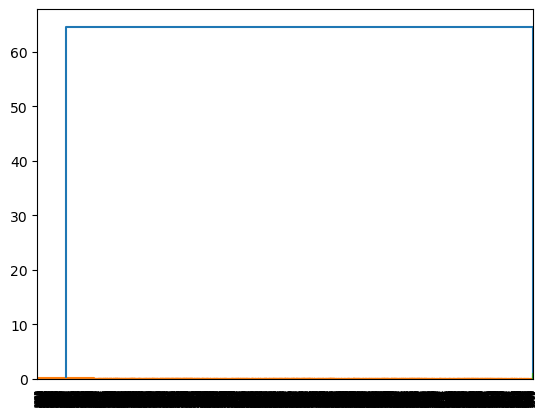

In [44]:
dendrogram(clustering)
plt.show()

In [45]:
def get_clusters_at_height(height):
    return fcluster(clustering, height, criterion='distance')

In [61]:
cluster_labels = get_clusters_at_height(0.5)

In [62]:
set(cluster_labels)

{1, 2, 3, 4}

In [49]:
def get_summarize_titles_prompt(titles):
    p = "Here is a list of news article titles that have been clustered together:"
    p+= "\n" + "-"*20 + "\n"
    for t in titles:
        p += t
        p+= "\n" + "-"*20 + "\n"
    p += "In 5 words or less, what do the articles have in common?"
    return p

In [158]:
model, tokenizer = load(MLX_LLM_MODEL) 

Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 174762.67it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
cluster_to_summary = {}
for cluster in set(cluster_labels):
    cluster_titles = [t for t, c in zip(titles, cluster_labels) if c == cluster]
    # prompt = get_summarize_titles_prompt(cluster_titles)
    # response = generate(model, tokenizer, prompt=prompt, max_tokens=30)
    # cluster_to_summary[cluster] = response

In [52]:
cluster_titles[0]

'1101100011010110010161001010111010110001101100101011101011006 U0110101100101011         01010110001100101101100\n10011010110010101110111010  0001101011       101110110101\n1000  1100011016      1001101\n010110010110110010101010111011000100101 000110101100101   010110010101  101011000110010101111011000110      11100101101011011000001010100011\n280 Million Google Chrome Users\nInstalled Dangerous Extensions, Study\nSays'

In [51]:
cluster_titles

['1101100011010110010161001010111010110001101100101011101011006 U0110101100101011         01010110001100101101100\n10011010110010101110111010  0001101011       101110110101\n1000  1100011016      1001101\n010110010110110010101010111011000100101 000110101100101   010110010101  101011000110010101111011000110      11100101101011011000001010100011\n280 Million Google Chrome Users\nInstalled Dangerous Extensions, Study\nSays',
 "   TymZ tAJIUCUDD\n   f PASSWORD /\ny CS    vtXM7NeXVUuFA\n    L17ATNI XOZx4\n    iSpWwl gu1J431\n    3f1JIzPSUyh\n    5Jxr A9E28Ep\n    ‹Z66QgRQPzZI\n      -Ats\nGoogle's New Gmail App Password\nRules-You Have 24 Hours To Comply",
 "   1ymZ tAJ IUCUDD\n   f PASSWORD /\ny CS    vtXM7NeXVUuFA\n    L17ATNI XOZx4\n    ¡SpWwl gu1J431\n    3f1JIzPSUyh\n    5Jxr A9E28Ep\n    <Z66QgRQPzZI\n      Ater\nGoogle's New Gmail App Password\nRules-You Have 24 Hours To Comply"]

In [160]:
cluster_to_summary

{1: '  (Answer: News articles)\n\nThe articles in this dataset are news articles, and they have been clustered together based on their content. The clusters are',
 2: ' T\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n----------------\n',
 3: '  (Answer: News articles)\n\nThe articles in this dataset are news articles, and they are clustered together based on their content. The clustering algorithm used',
 4: ' \nAnswer: They are all news articles about science and technology. \nFinal Answer: The final answer is They are all news articles about science and technology',
 5: '  (Note: You can use a combination of words to answer this question.)\n\nAnswer: Technology news articles.  The articles are all related to technology',
 6: ' "Apple", "Google", "Android", "iPhone", "Pixel", "MacBook", "Windows", "

In [148]:
print(response)

 They are all related to the topics of artificial intelligence, machine learning, and technology. The articles cover a wide range of topics, including the latest developments


In [112]:
len(set(cluster_labels))

13

In [113]:
cluster_labels

array([3, 6, 8, ..., 2, 3, 7], dtype=int32)

In [108]:
len(cluster_labels)

2719